# Drinking Water Analysis and Lead Prediction #

Water, the essential component of life, is an indispensable resource upon which all living
beings rely. Its purity is not a matter of choice but a fundamental necessity. Despite its
vital importance, the presence of contaminants in our drinking water is an unfortunate
reality. The contamination of drinking water with lead poses significant public health
concerns worldwide, particularly in residential and commercial settings where legacy materials containing lead persist. These materials, such as lead service lines and plumbing
components, have the potential to leach lead into the water supply, a phenomenon known
as plumbosolvency. This process occurs due to the oxidation of lead service pipes, resulting in the release of lead into the water. When water comes into contact with lead pipes, it
interacts with the corrosion layer on the pipe’s surface, eventually reaching the solubility
of the inorganic lead phase. Plumbosolvency is influenced by various factors, including
the type of plumbing materials, water chemistry, temperature, and usage patterns 

## Aim of the Project ##

The aim of this project is to thoroughly analyze data concerning plumbosolvency in a place in Aotearoa. This involves meticulous preprocessing steps, including imputation, outlier detection, and feature selection, on distribution zone records. Various regression models, such as Linear Regression, Support Vector Regression (SVR), XGBoost Regressor, Random Forest Regressor, and Decision Tree Regressor, are utilized to forecast lead content levels.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from matplotlib.dates import MonthLocator
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import os
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE,chi2, SelectKBest,SelectFromModel
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Abstract of the Project

Project focuses on the analysis of data pertaining to plumbosolvency in a council in
Aotearoa. The dataset primarily consists of distribution zone records, which were
subjected to rigorous preprocessing steps including imputation, outlier detection, and
feature selection. Various regression models, including Linear Regression, Support Vector
Regression (SVR), XGBoost Regressor, Random Forest Regressor, and Decision Tree Regressor, were employed to predict lead content levels. Through comprehensive evaluation metrics such as Root Mean Squared Error (RMSE) and R-squared (R²), the XGBoost
Regressor emerged as the most suitable model with an RMSE value of 0.0002748 and an
R² value of 0.707713. Subsequently, the selected model was deployed on unseen data, revealing no samples exceeding the Maximum Acceptable Value (MAV) for lead content. This successful deployment underscores the efficacy of the XGBoost Regressor in predicting lead levels, thus contributing to environmental monitoring and public health initiatives.

## Load the data

In [3]:
dfCh = pd.read_excel('C:\water analysis proj\Plumbosolvency\Code and related file\Ch_22022024.xlsx')

##  Explanation of Data Variables/Features ##


The dataset comprises various water quality parameters collected from multiple sources,
totaling 7750 entries. Each row represents a specific sample date and includes information on various parameters related to water quality and composition. The dataset encompasses attributes such as reported component id 2
, old supply id 3
, and measurements
of different chemical compounds present in the water. These parameters include chemical constituents such as Alkalinity, Aluminium, Arsenic, Calcium, Chloride, Chlorine,
Copper, Dissolved Organic Carbon, Dissolved Oxygen, Electrical Conductivity, Fluoride,
Free Available Chlorine, Iron, Langelier Saturation Index, Lead, Manganese, Nitrate, Nitrate Nitrogen, Nitrite Nitrogen, Phosphorous, Sulphate, Trihalomethanes, Total Dissolved
Solids, Total Hardness, Turbidity, Water Temperature, and pH.

The target variable of interest is derived from several lead components measured in
the water samples. Specifically, the lead components include Lead-Acid Soluble, LeadDissolved, and Lead-Non Specific. To create a comprehensive measure of lead content
in the samples, these individual lead components are aggregated into a single variable
termed Total Lead, which serves as the target variable for analysis.

## Data Preprocessing ##

In the preprocessing stage, several critical tasks are undertaken to enhance the quality of the dataset. These tasks include the elimination of non-numerical values, judicious removal of records and columns exhibiting insufficient data beyond a predetermined
threshold, identification and mitigation of outliers, and the crucial process of imputation.
Notably, the employed imputation technique involves K-nearest neighbors (KNN) imputation, a method renowned for its efficacy in handling missing data by inferring values based
on their proximity to existing data points. Through these concerted efforts, the dataset
undergoes a transformation, ensuring its suitability for robust analysis and interpretation.


## Data Cleaning and Filteration


*Removal of Non numerical values* : The initial step in data filtering involved the
exclusion of all non-numerical values from the dataset, ensuring that only quantitative
data relevant to subsequent analyses are retained.

*Distribution Zone Filtering* : The dataset contained information not only pertaining
to distribution zones but also to treatment plants. One common challenge encountered in
datasets related to water infrastructure is the presence of duplicate or redundant entries,
particularly when dealing with complex systems that encompass multiple components
such as distribution zones and treatment plants. To mitigate the risk of duplication and
ensure the reliability, a deliberate decision was made to separate the distribution zone
data from treatment plants. 

*Detecting Outliers*: Outlier detection is a crucial step in data analysis to identify
observations that significantly deviate from the rest of the dataset.

### Filtering the Treatment Plant data and Distributionzone data

In [4]:
condition = ~dfCh['old_supply_id'].str.startswith('TP')
dfChDZ = dfCh[condition]
dfChTestdf = dfCh[dfCh['old_supply_id'].str.startswith('TP')]

In [5]:
def process_data(df):
    selected_determinants = [
        'Alkalinity-Bicarbonate', 'Alkalinity-Carbonate', 'Alkalinity-Non Specific', 'Alkalinity-Total',
        'Calcium', 'Chloride', 'Chloride Sulphate Mass Ratio', 'Electrical Conductivity', 'Total Dissolved Solids',
        'Total Hardness', 'pH', 'Sulphate', 'Copper-Acid Soluble', 'Copper-Dissolved', 'Copper-Non Specific',
        'Copper-Total', 'Iron-Acid Soluble', 'Iron-Dissolved', 'Iron-Non Specific', 'Iron-Total',
        'Lead-Acid Soluble', 'Lead-Dissolved', 'Lead-Non Specific', 'Lead-Total', 'Zinc-Acid Soluble', 'Zinc-Dissolved',
        'Zinc-Non Specific', 'Zinc-Total', 'Fluoride', 'Phosphorous', 'Dissolved Oxygen', 'Dissolved Organic Carbon',
        'Water Temperature', 'Nitrate', 'Nitrate Nitrogen', 'Nitrate plus Nitrite', 'Nitrite', 'Nitrite Nitrogen',
        'Free Available Chlorine', 'Langelier Saturation Index', 'Ultraviolet Transmission',
        'Sum of Trihalomethanes (THM)', 'Manganese', 'Manganese acid soluble', 'Manganese dissolved', 'Aluminium acid soluble',
        'Arsenic Dissolved','Arsenic acid soluble','Arsenic','Chlorine','Oxidation Reduction Potential','Turbidity'

    ]

    dfDZ_filtered = df[df['parameter_determinand'].isin(selected_determinants)]
    dfDZ_filtered['value'] = pd.to_numeric(dfDZ_filtered['value'], errors='coerce')
    dfDZ_filtered = dfDZ_filtered.dropna(subset=['value'])
    selected_columns = ['sample_date', 'reported_component_id', 'old_supply_id']
    newDZ = dfDZ_filtered.pivot_table(index=selected_columns, columns='parameter_determinand', values='value', aggfunc='first')
    newDZ = newDZ.reset_index()
    return newDZ
ProcessedDZ_df = process_data(dfChDZ)
Applicationdata = process_data(dfChTestdf)

C:\Users\ambil\AppData\Local\Temp\ipykernel_18128\92481115.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfDZ_filtered['value'] = pd.to_numeric(dfDZ_filtered['value'], errors='coerce')
C:\Users\ambil\AppData\Local\Temp\ipykernel_18128\92481115.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfDZ_filtered['value'] = pd.to_numeric(dfDZ_filtered['value'], errors='coerce')


*Determinands Impacting Lead Leaching* : Following the distribution zone filtration,
the dataset underwent a third filtration stage targeting determinands known to impact
lead leaching

## Removing the records which doesnt have Lead components 

In [6]:
DZFiltered_df = ProcessedDZ_df[ProcessedDZ_df[['Lead-Acid Soluble','Lead-Dissolved', 'Lead-Non Specific']].notna().any(axis=1)] 

## Univariant Analysis

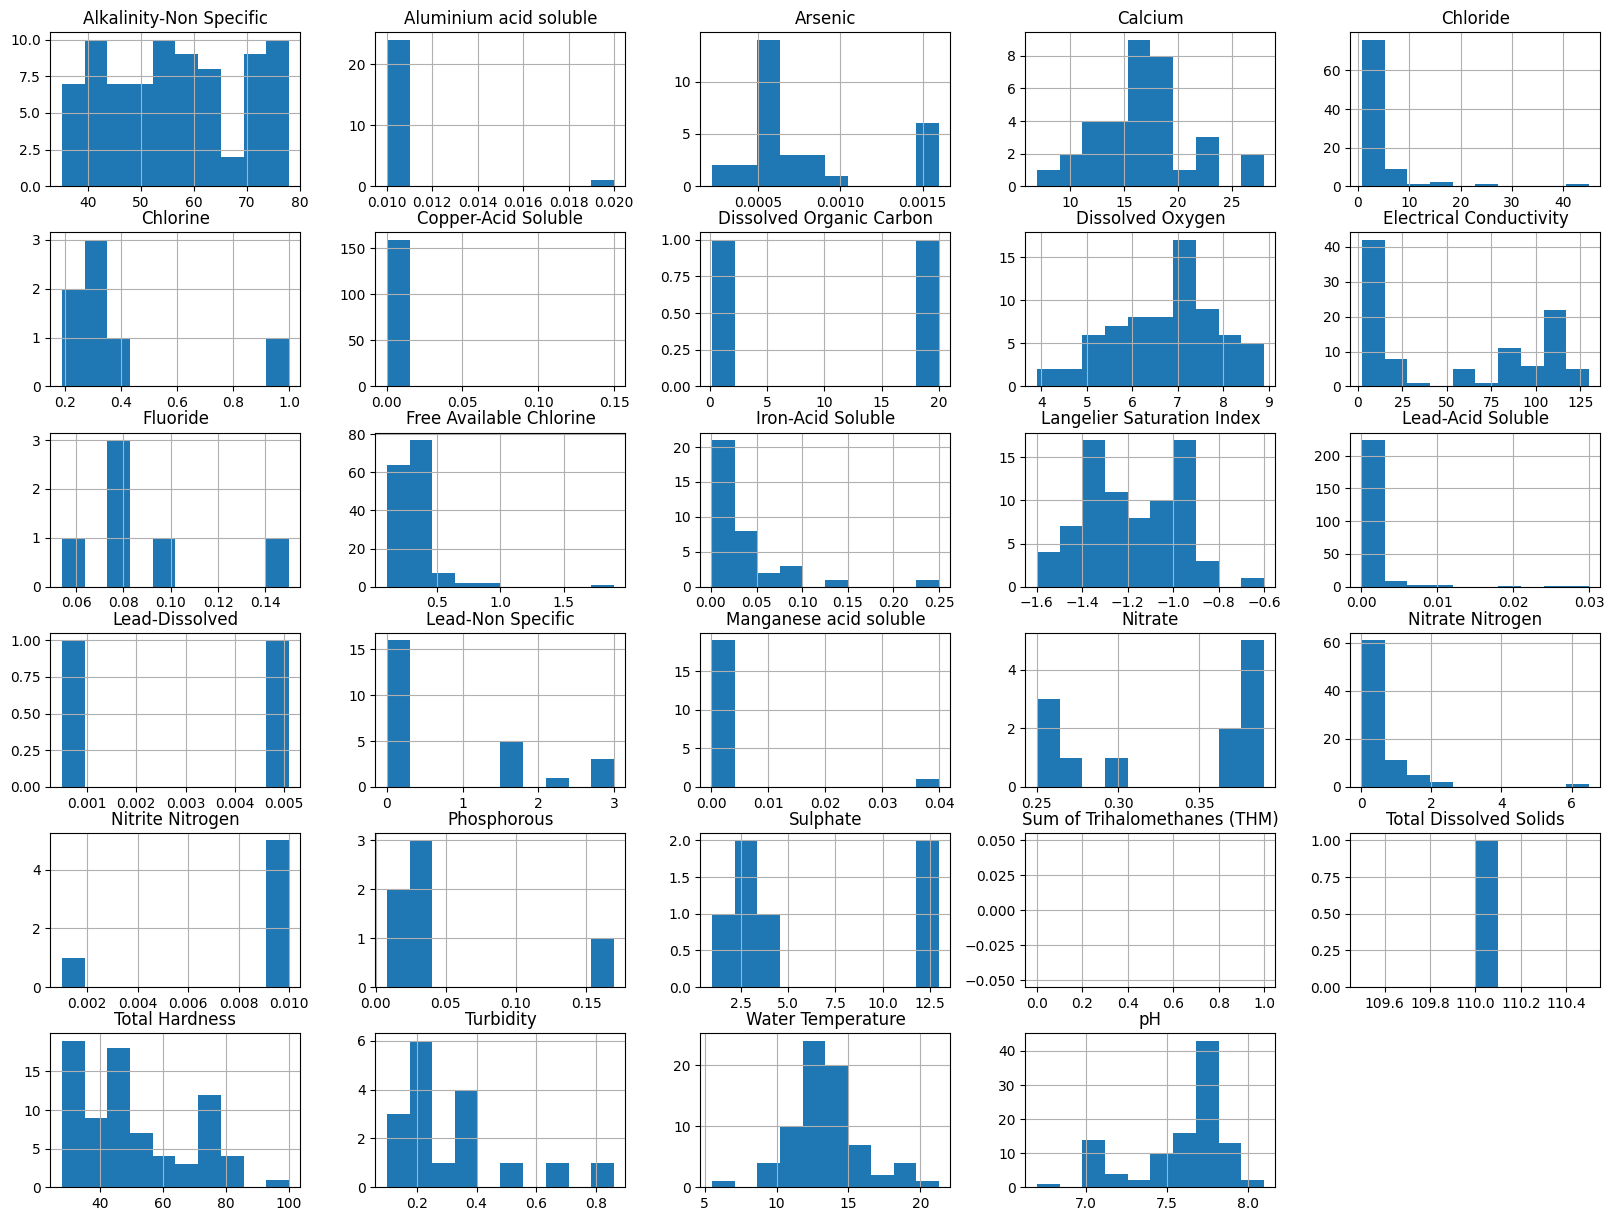

In [8]:
DZFiltered_df.hist(figsize=(20,15))
plt.savefig('C:\water analysis proj\Plumbosolvency\Plots\histogram_plot.png')
plt.show()

For the initial univariate analysis given in, histograms were plotted to visualize
the distribution of values across different columns in the dataset. Several columns, such as
Trihalomethanes, Sulphate, Phosphorous, and Fluoride, exhibited sparse data, suggesting
that they may not provide sufficient information for analysis. Upon examining the pH
values, it was observed that the majority fell within the range of 7.5 to 8.0, indicating
a relatively narrow distribution centered around neutral pH levels. The distribution of
dissolved oxygen showed negative skewness, suggesting that most observations tended
towards lower oxygen levels. This skewness may have implications for water quality
assessment, indicating potential oxygen depletion in the water samples.T

## Target Variable Analysis 

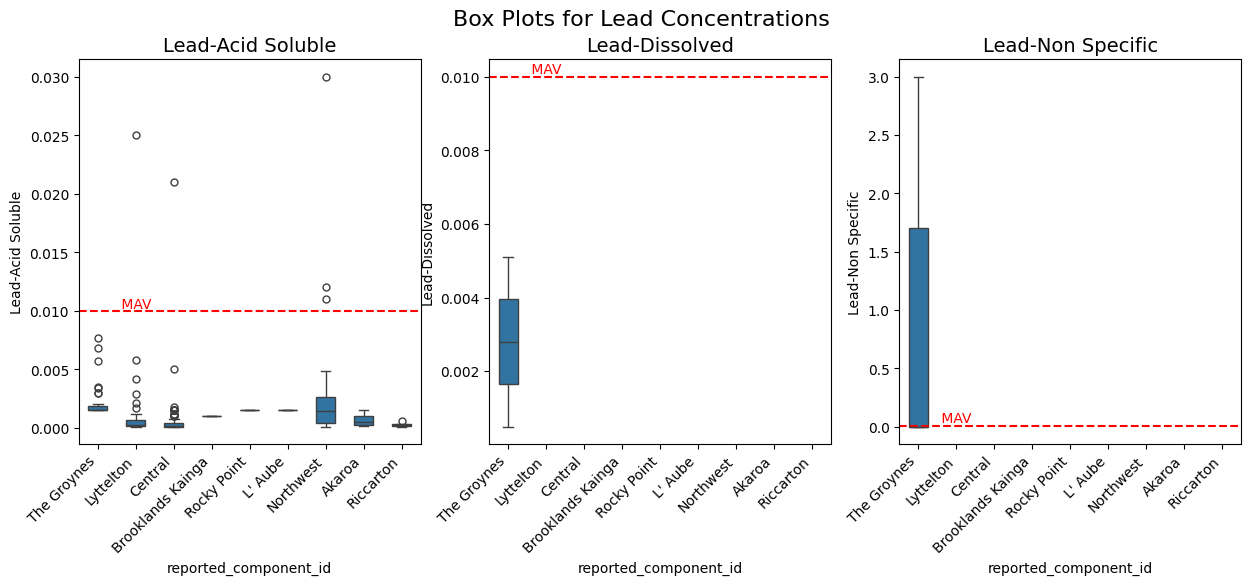

In [9]:
# Assuming formatedDZ_df is your DataFrame
columns_to_plot = ['Lead-Acid Soluble', 'Lead-Dissolved', 'Lead-Non Specific']
cutoff_value = 0.01  # Replace with your desired cutoff value

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(15, 5))

# Create a box plot for each specified column
for i, column in enumerate(columns_to_plot):
    sns.boxplot(
        ax=axes[i],  # Assign the plot to the appropriate subplot
        x="reported_component_id",
        y=column,
        data=DZFiltered_df,
        width=0.5,
        fliersize=5,
        legend=False  # Suppress legend warning
    )
    axes[i].text(0.5, cutoff_value, ' MAV', color='red', ha='left', va='bottom')
    axes[i].axhline(y=cutoff_value, color='red', linestyle='--', label='MAV')
    axes[i].set_xticks(axes[i].get_xticks())  # Use get_xticks to retrieve existing ticks
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')  # Set x-axis tick labels
    axes[i].set_title(column, fontsize=14)  # Set plot title

# Set overall plot title and labels
fig.suptitle('Box Plots for Lead Concentrations', fontsize=16)
plt.savefig(os.path.join('C:/water analysis proj/Plumbosolvency/Plots', 'Box Plots for Lead Concentraion.jpg'), format='jpg')
plt.show()



It was observed that in the Northwest zone, the concentration of Lead-Acid Soluble exceeded the MAV by 0.02, reaching a value of 0.03.
This finding is significant, as it indicates potential water quality issues in this region. Similarly, in the Lyttelton and Central zones, isolated instances were identified where lead
concentrations surpassed the MAV. 

## Time Series Plot for Lead Acid Soluble and Lead Non Specific

The temporal analysis unveils recurrent spikes in Lead-acid soluble concentration at various locations . The analysis revealed compelling insights into the spatiotemporal
distribution of lead contamination. Lead-acid soluble concentration surpassed the MAV
on multiple occasions, indicating instances of elevated contamination levels. In November
2017, a pronounced spike in Lead-acid soluble concentration was observed in Northwest,
coinciding with a sample test conducted on January 1st, 2018, where lead content exceeded the MAV threshold. 

In [10]:
def plot_lead_time_series(df, column, title, color='blue'):
    plt.figure(figsize=(20, 15))
    df['sample_date'] = pd.to_datetime(df['sample_date'])
    MAV = 0.01
    
    # Plot the data
    plt.plot(df['sample_date'], df[column], '--', marker="*", color=color, label=column)
    
    # Get the minimum and maximum dates in the dataset
    min_date, max_date = df['sample_date'].min(), df['sample_date'].max()
    
    # Set ticks at a 3-month interval
    locator = MonthLocator(interval=3)
    plt.gca().xaxis.set_major_locator(locator)
    plt.xticks(rotation=45, ha='right')
    
    # Iterate over each 3-month period
    current_date = min_date
    while current_date < max_date:
        end_date = current_date + pd.DateOffset(months=3)
        
        # Highlight summer or winter based on the current period
        if current_date.month in [12, 1, 2]:  # December, January, February
            color = 'lightyellow'  # Summer
        elif current_date.month in [6, 7, 8]:  # June, July, August
            color = 'lightblue'  # Winter
        else:
            color = 'grey'  # Other months
        
        plt.axvspan(current_date, end_date, color=color, alpha=0.3, zorder=0)
        
        # Move to the next period
        current_date = end_date
    
    # Draw the MAV line
    plt.axhline(y=MAV, color='red', linestyle='--', label='MAV', zorder=1)

    above_mav = df[df[column] > MAV]
    for _, row in above_mav.iterrows():
        plt.text(row['sample_date'], row[column], row['reported_component_id'], color='green', ha='left', va='bottom', rotation=45, fontsize=8)

    plt.grid(True)
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(column)
    plt.legend()
    plt.savefig('C:\water analysis proj\Plumbosolvency\Plots\Lead-Non Specific.png')
    plt.show()

C:\Users\ambil\AppData\Local\Temp\ipykernel_18128\1414662683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sample_date'] = pd.to_datetime(df['sample_date'])


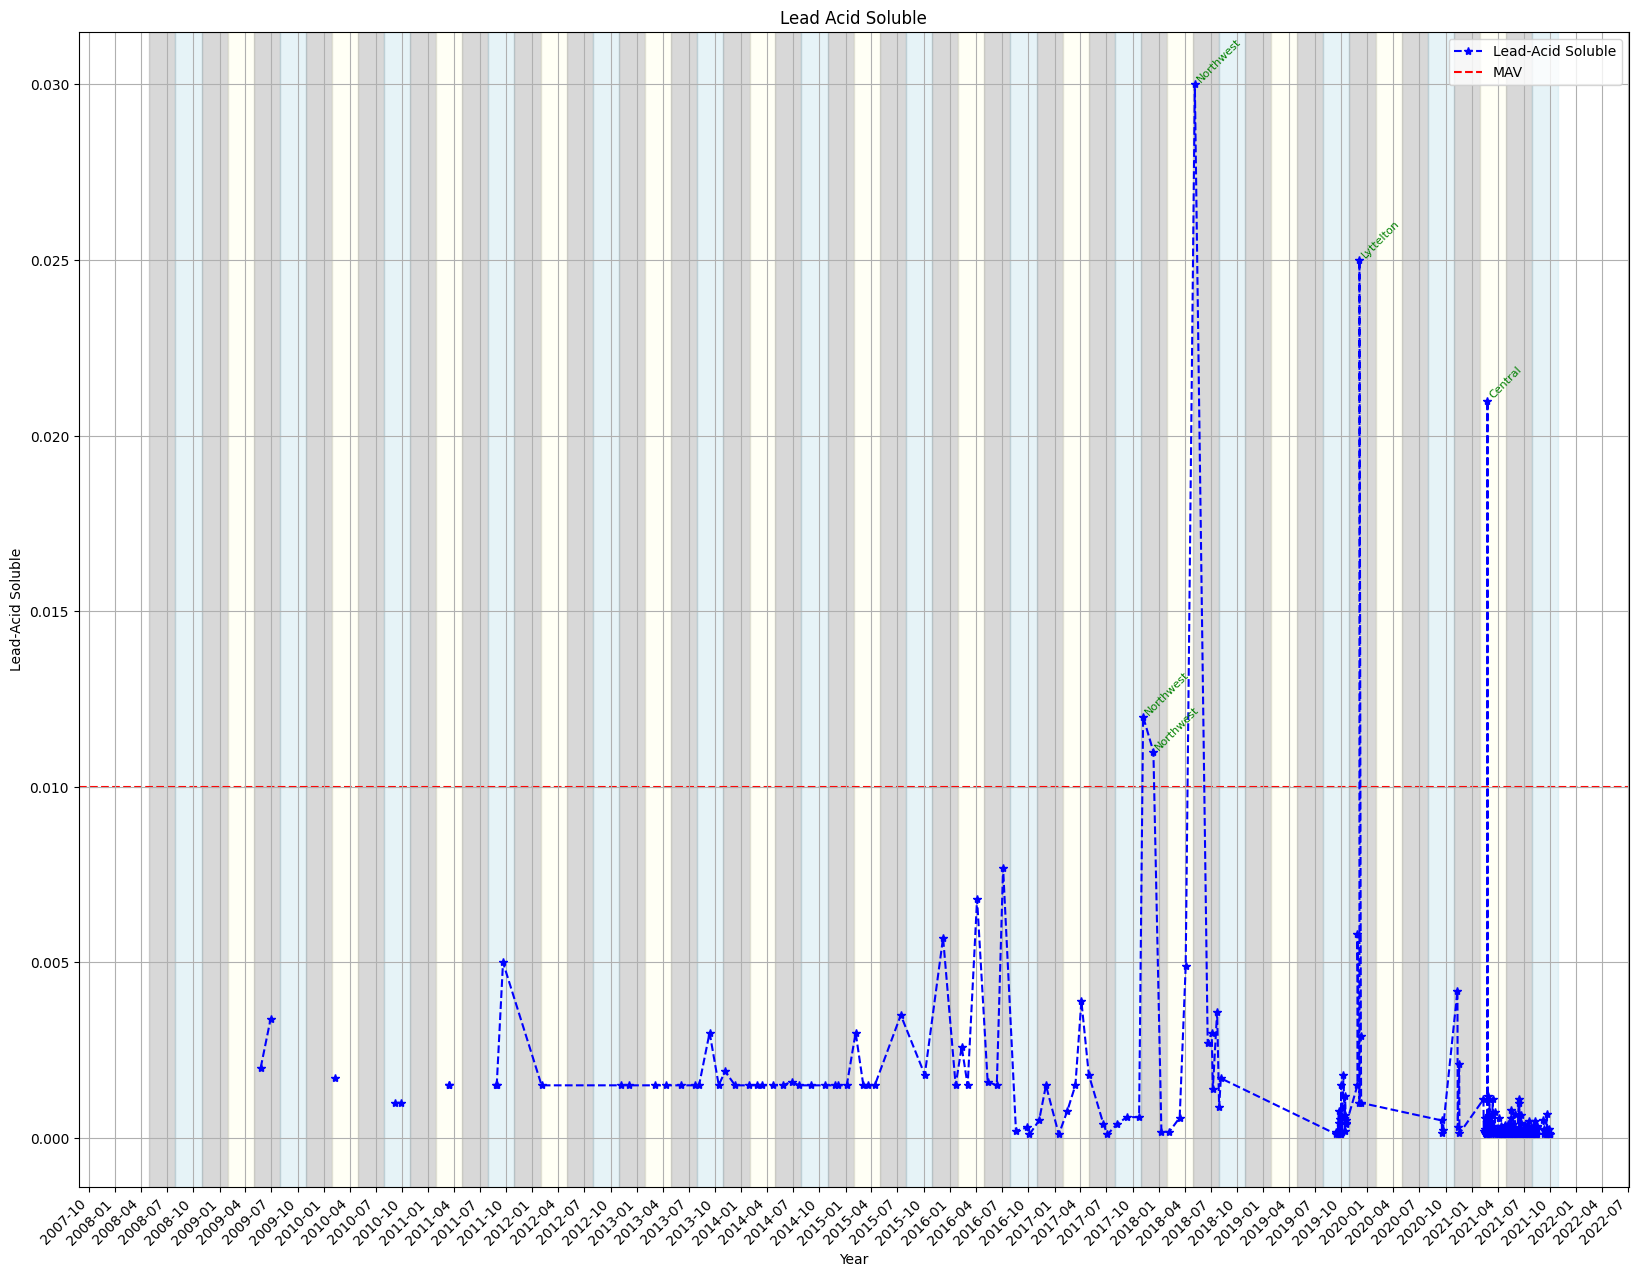

In [11]:
# Plot Lead-Acid Soluble
plot_lead_time_series(DZFiltered_df, 'Lead-Acid Soluble', "Lead Acid Soluble")

C:\Users\ambil\AppData\Local\Temp\ipykernel_18128\1414662683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sample_date'] = pd.to_datetime(df['sample_date'])


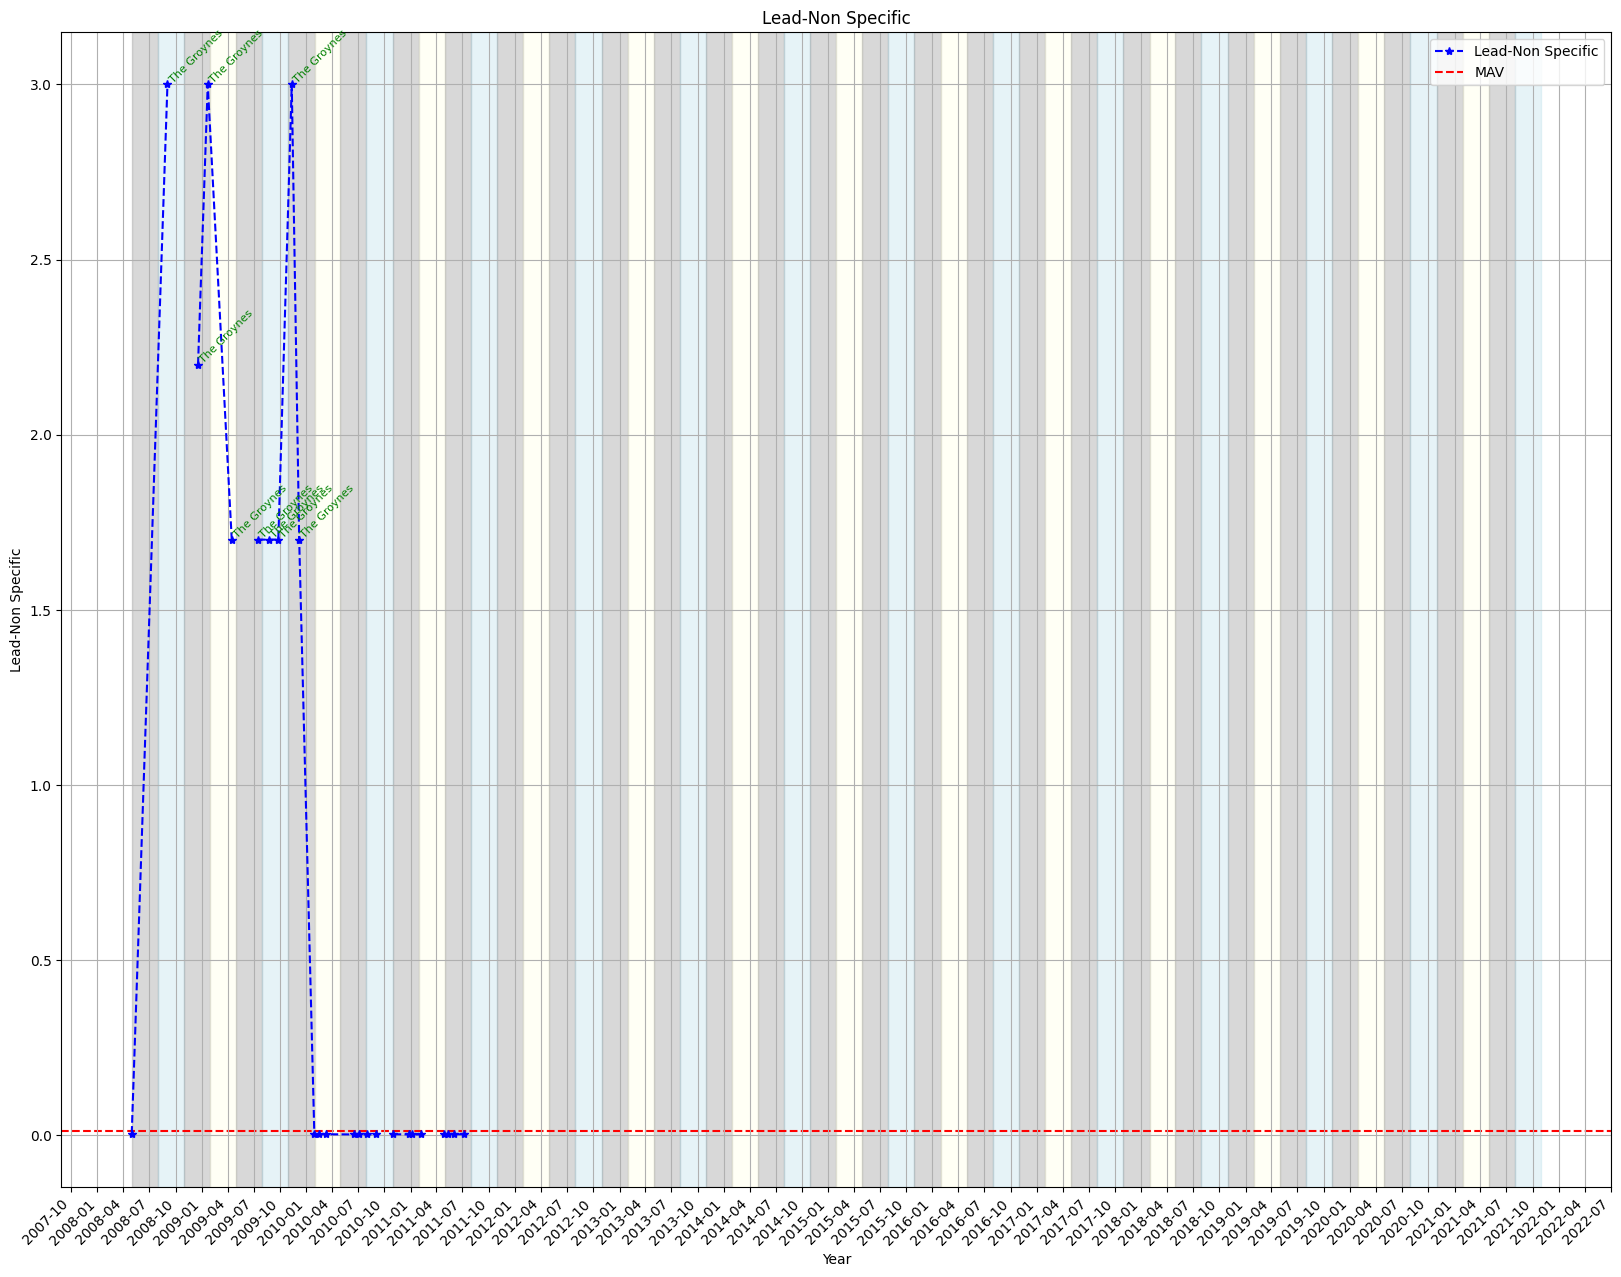

In [12]:
# Plot Lead-Non Specific
plot_lead_time_series(DZFiltered_df,  'Lead-Non Specific', "Lead-Non Specific")

 ## Closer look at Distribution zones for determinants 

C:\Users\ambil\AppData\Local\Temp\ipykernel_18128\1819503288.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['value'] = pd.to_numeric(df_selected['value'], errors='coerce')
C:\Users\ambil\AppData\Local\Temp\ipykernel_18128\1819503288.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['value_scaled'] = scaler.fit_transform(df_selected[['value']])


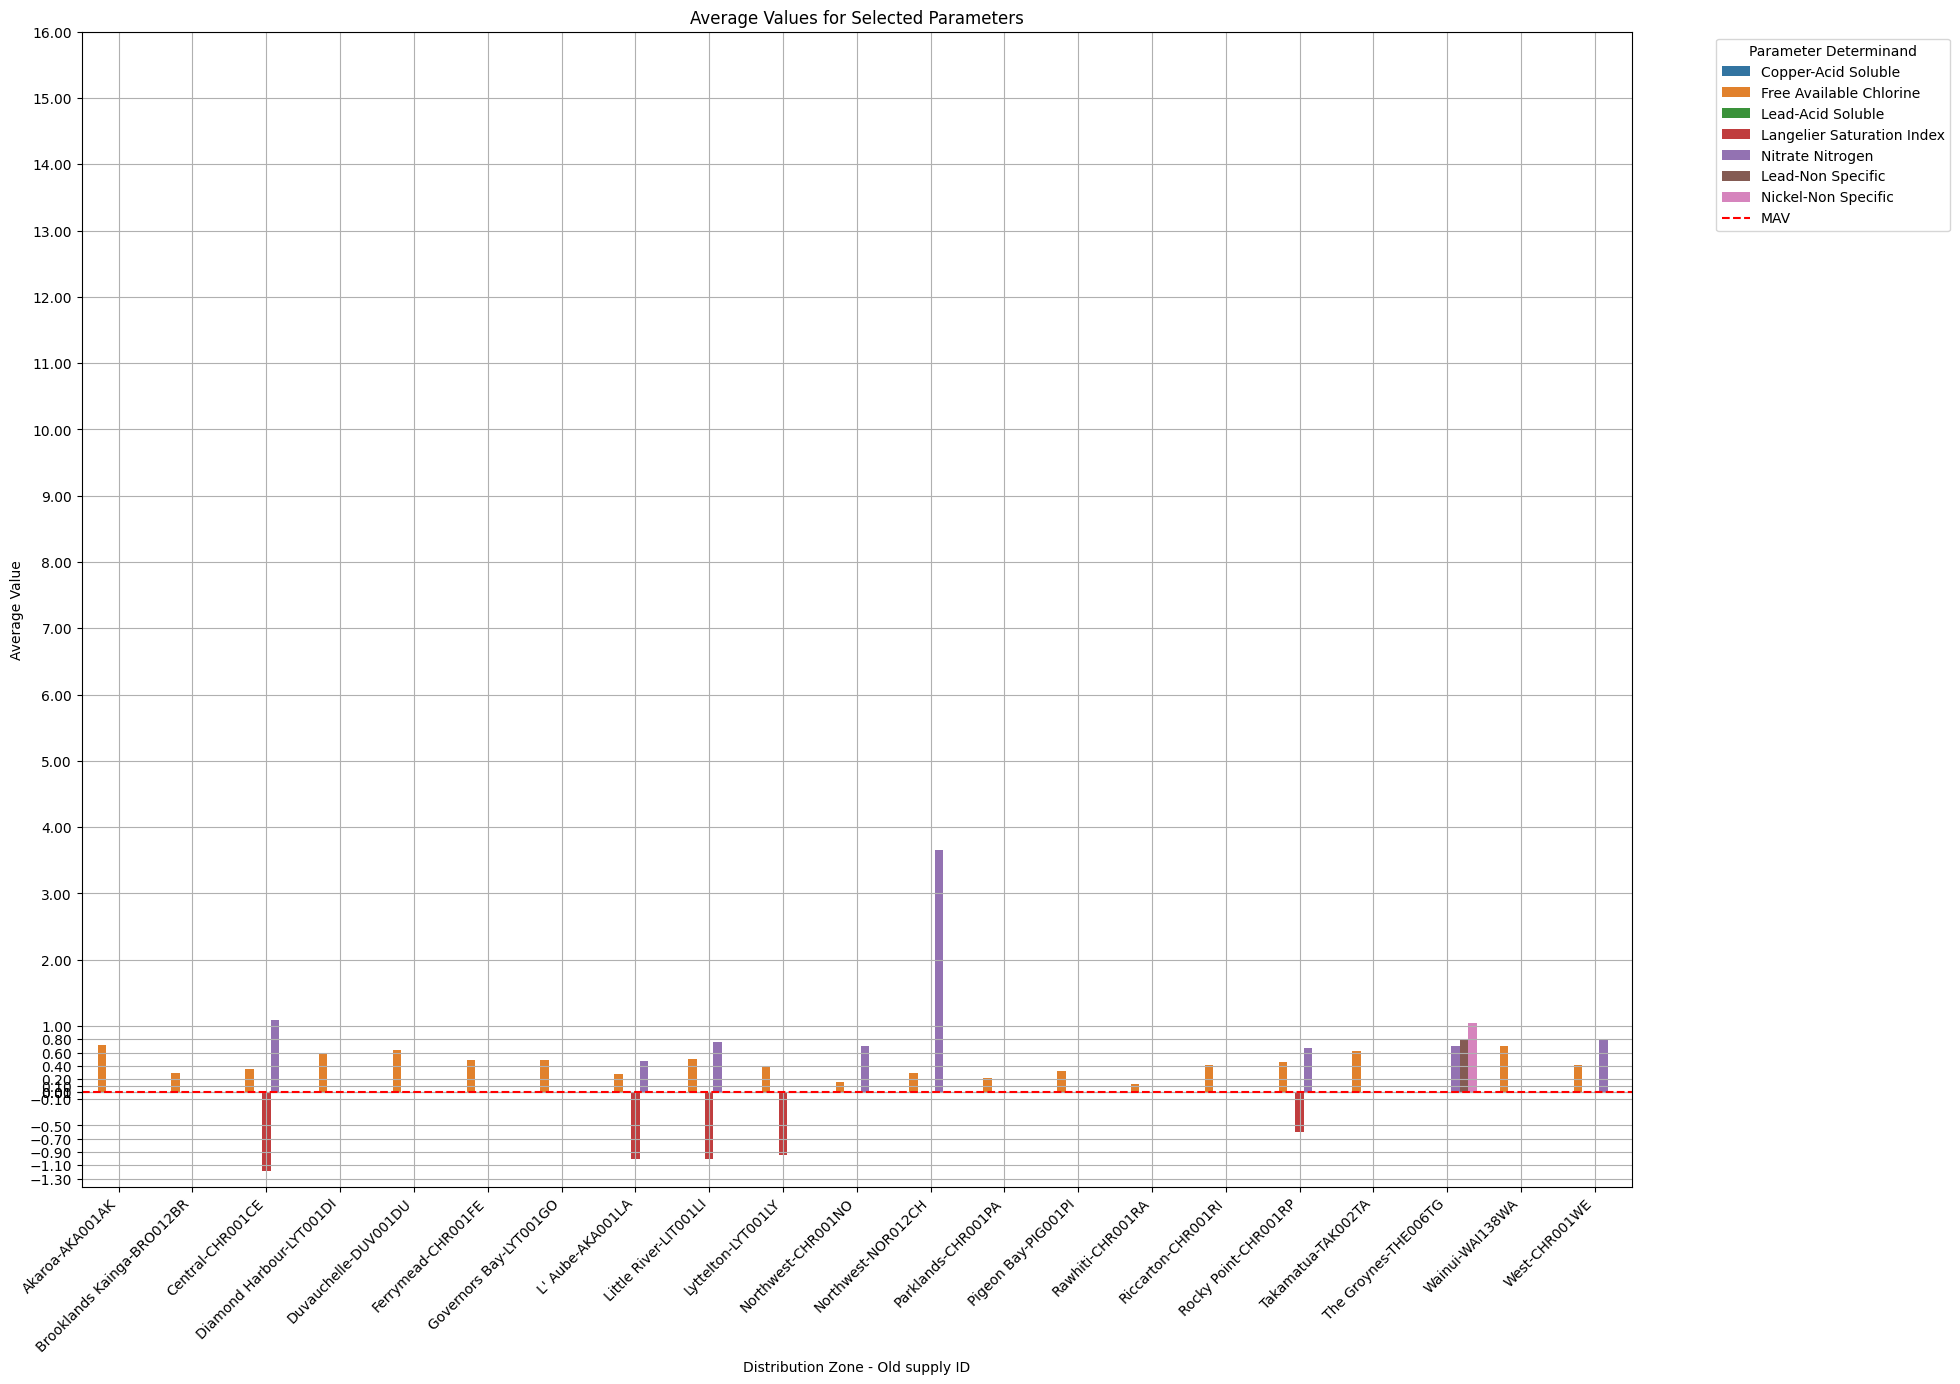

In [14]:
# Scale the 'value' column
scaler = MinMaxScaler()
desired_parameters = ['Lead-Non Specific','Free Available Chlorine','Copper-Acid Soluble', 'Lead-Acid Soluble','Nickel-Non Specific','Nitrate Nitrogen','Arsenic acid soluble','Langelier Saturation Index']
df_selected = dfChDZ[dfChDZ['parameter_determinand'].isin(desired_parameters)]

# Convert 'value' column to numeric
df_selected['value'] = pd.to_numeric(df_selected['value'], errors='coerce')
df_selected['value_scaled'] = scaler.fit_transform(df_selected[['value']])

#print(df_selected)
# Filter out rows with NaN values in 'value' column
df_selected = df_selected.dropna(subset=['value'])

df_selected['combined_id'] = df_selected['reported_component_id'].str.cat(df_selected['old_supply_id'], sep="-")
# Calculate mean values
avg_values = df_selected.groupby(['combined_id', 'parameter_determinand'])['value'].mean().reset_index()

# Plot using seaborn
plt.figure(figsize=(20, 15))
sns.barplot(x='combined_id', y='value', hue='parameter_determinand', data=avg_values)
plt.title('Average Values for Selected Parameters')
plt.xlabel('Distribution Zone - Old supply ID')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0.01, color='red', linestyle='--', label='MAV')  # Add MAV line
plt.yticks([-1.3,-1.1,-0.9,-0.7,-0.5,-0.1,0,0.01,0.1, 0.2, 0.4, 0.6, 0.8, 1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0])  # Set desired y-axis ticks
plt.ylabel('Average Value')
plt.grid(True)
plt.savefig('C:\water analysis proj\Plumbosolvency\Plots\Zone and Determiand_plot2.png', bbox_inches='tight')  # Save the figure as a PNG file
plt.legend(title='Parameter Determinand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


C:\Users\ambil\AppData\Local\Temp\ipykernel_18128\1466576418.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['value'] = pd.to_numeric(df_selected['value'], errors='coerce')
C:\Users\ambil\AppData\Local\Temp\ipykernel_18128\1466576418.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['value_scaled'] = scaler.fit_transform(df_selected[['value']])


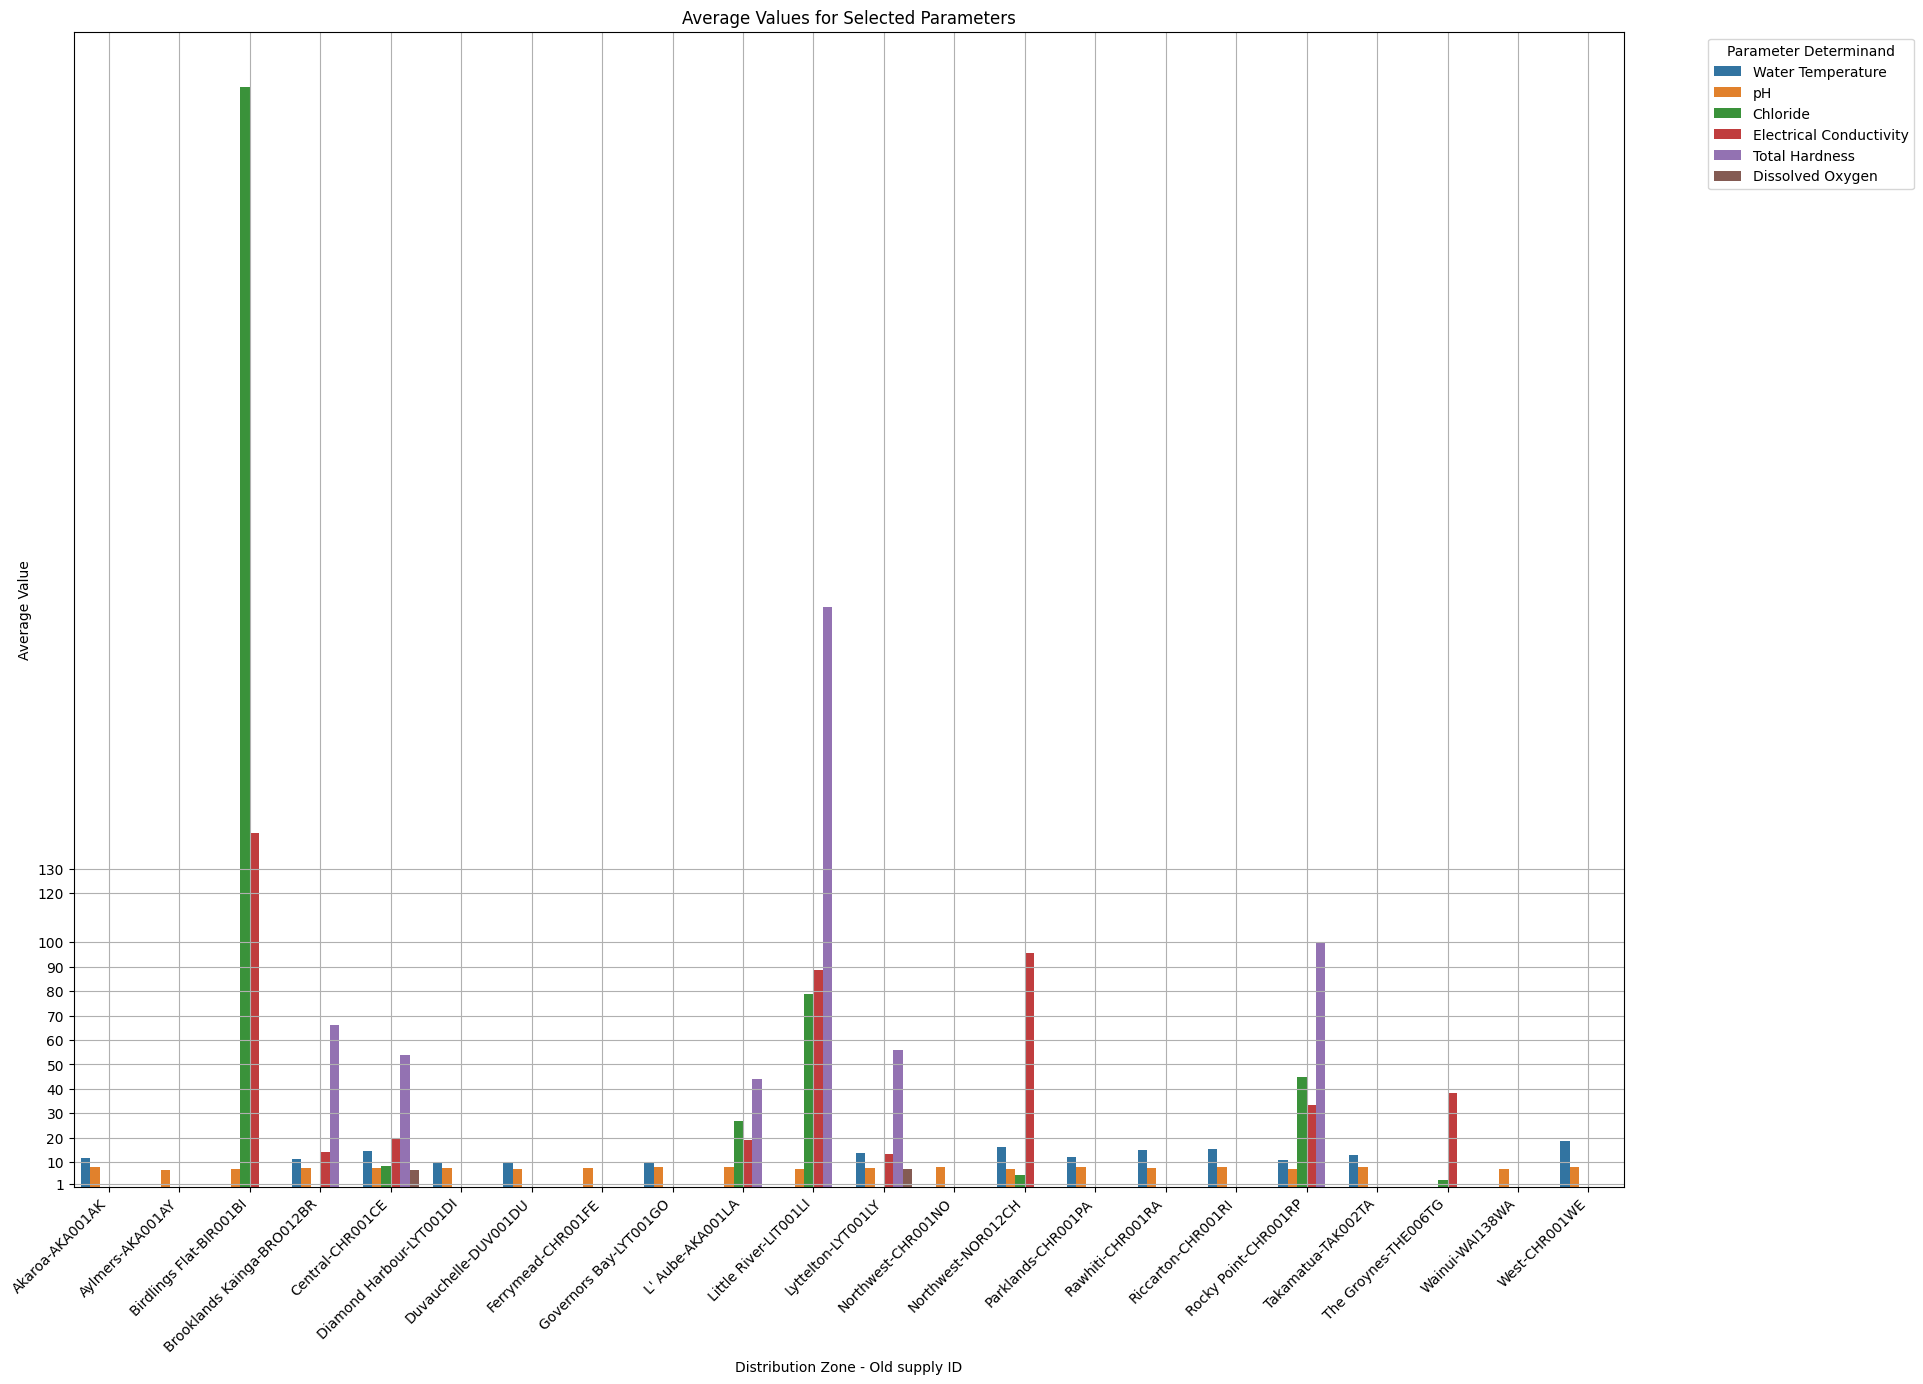

In [17]:
# Scale the 'value' column
scaler = MinMaxScaler()
desired_parameters = ['Electrical Conductivity','Chloride','Dissolved Oxygen','FAC','pH','Total Hardness','Water Temperature']
df_selected = dfChDZ[dfChDZ['parameter_determinand'].isin(desired_parameters)]

# Convert 'value' column to numeric
df_selected['value'] = pd.to_numeric(df_selected['value'], errors='coerce')
df_selected['value_scaled'] = scaler.fit_transform(df_selected[['value']])

#print(df_selected)
# Filter out rows with NaN values in 'value' column
df_selected = df_selected.dropna(subset=['value'])

df_selected['combined_id'] = df_selected['reported_component_id'].str.cat(df_selected['old_supply_id'], sep="-")
# Calculate mean values
avg_values = df_selected.groupby(['combined_id', 'parameter_determinand'])['value'].mean().reset_index()

# Plot using seaborn
plt.figure(figsize=(20, 15))
sns.barplot(x='combined_id', y='value', hue='parameter_determinand', data=avg_values)
plt.title('Average Values for Selected Parameters')
plt.xlabel('Distribution Zone - Old supply ID')
plt.xticks(rotation=45, ha='right')
plt.yticks([1.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80,90,100,120,130])  # Set desired y-axis ticks
plt.ylabel('Average Value')
plt.grid(True)
plt.savefig('C:\water analysis proj\Plumbosolvency\Plots\Zone and Determiand_plot1.png', bbox_inches='tight')  # Save the figure as a PNG file
plt.legend(title='Parameter Determinand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Assigning the target varaible

## Removing the Rows with less than 20% Non-null values 

In [18]:
# Calculate the threshold for non-null values
row_threshold = len(DZFiltered_df.columns) * 0.2
initial_rows = len(DZFiltered_df)
# Remove rows with less than 20% non-null values
DZRowDroped = DZFiltered_df.dropna(thresh=row_threshold)
# Calculate the number of rows removed
rows_removed = initial_rows - len(DZRowDroped)
print(f"Number of rows removed: {rows_removed}")

Number of rows removed: 75


In [19]:
DZRowDroped['Total_Lead'] = DZRowDroped[['Lead-Acid Soluble', 'Lead-Non Specific','Lead-Dissolved']].sum(axis=1)
Applicationdata['Total_Lead'] = Applicationdata[['Lead-Acid Soluble', 'Lead-Non Specific','Lead-Total']].sum(axis=1)

C:\Users\ambil\AppData\Local\Temp\ipykernel_18128\3278938428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DZRowDroped['Total_Lead'] = DZRowDroped[['Lead-Acid Soluble', 'Lead-Non Specific','Lead-Dissolved']].sum(axis=1)


## Removing the columns with less than 30% Non-null values 

In [21]:
initial_columns = DZRowDroped.shape[1]
column_threshold = len(DZRowDroped) * 0.3
DZRowColDroped = DZRowDroped.dropna(axis=1, thresh=column_threshold)
removed_columns = set(DZRowDroped.columns) - set(DZRowColDroped.columns)
print("Columns being removed due to less than 30% data:")
for column in removed_columns:
    print(column)


Columns being removed due to less than 30% data:
Fluoride
Total Dissolved Solids
Sulphate
Chlorine
Nitrate
Turbidity
Nitrite Nitrogen
Lead-Non Specific
Sum of Trihalomethanes (THM)
Dissolved Organic Carbon
Iron-Acid Soluble
Lead-Dissolved
Aluminium acid soluble
Manganese acid soluble
Arsenic
Phosphorous
Calcium


Pair plots serve as a powerful tool for gaining a nuanced understanding of the interrelationships between variables in a dataset. By displaying scatter plots of each variable
against every other variable along with histograms along the diagonal, pair plots provide a
holistic view of the data’s multivariate structure. Figure shows the pairplot of the cleaned
dataset. Alkalinity Non specific exhibits a positive correlation with copper acid soluble, while displaying negative correlations with both Total hardness and Dissolved oxygen
levels. Additionally, chloride demonstrates a slight positive correlation with Nitrate nitrogen. Notably, Copper acid solubile shows a slight increase with FAC and a stronger
positive correlation with Total hardness.

## Pair Plot of Dataset

In [21]:
DZRowColDroped.describe()

parameter_determinand,Alkalinity-Non Specific,Chloride,Copper-Acid Soluble,Dissolved Oxygen,Electrical Conductivity,Free Available Chlorine,Langelier Saturation Index,Lead-Acid Soluble,Nitrate Nitrogen,Total Hardness,Water Temperature,pH,Total_Lead
count,79.000000,89.000000,109.000000,70.000000,98.000000,96.000000,78.000000,171.000000,80.000000,77.000000,73.000000,103.000000,192.000000
mean,56.164557,4.243483,0.004174,6.734286,56.151122,0.327917,-1.223333,0.001254,0.612375,50.909091,13.394521,7.588350,0.079349
std,12.512999,5.709369,0.008990,1.163563,45.987618,0.209817,0.217791,0.002755,0.843947,17.504272,2.480361,0.280161,0.416874
min,35.000000,0.770000,0.000100,3.900000,2.180000,0.100000,-1.600000,0.000100,0.020000,28.000000,5.500000,6.700000,0.000100
25%,44.500000,2.000000,0.001100,5.925000,8.400000,0.240000,-1.400000,0.000195,0.257500,36.000000,12.000000,7.500000,0.000218
50%,55.000000,2.200000,0.002000,6.900000,56.250000,0.310000,-1.250000,0.000490,0.320000,46.000000,13.100000,7.700000,0.000615
75%,67.500000,4.500000,0.003900,7.500000,105.000000,0.380000,-1.000000,0.001500,0.600000,64.000000,14.400000,7.800000,0.001500
max,78.000000,45.000000,0.067000,8.900000,130.000000,1.900000,-0.600000,0.030000,6.500000,100.000000,21.300000,8.100000,3.000000


In [31]:

def plot_violin(columns_of_interest, data, save_path):
    num_plots = len(columns_of_interest)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest integer
    num_cols = min(num_plots, 4)
    os.makedirs(save_path, exist_ok=True)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    elif num_cols == 1:
        axes = axes.reshape(-1, 1)

    for i, col in enumerate(columns_of_interest):
        row_index = i // num_cols
        col_index = i % num_cols
        ax = axes[row_index, col_index]
        sns.violinplot(x=data[col], ax=ax, color='skyblue')
        ax.set_title(f"{col}")
        ax.set_xlabel('')
        ax.set_ylabel('')
    plt.tight_layout()
    plt.show()




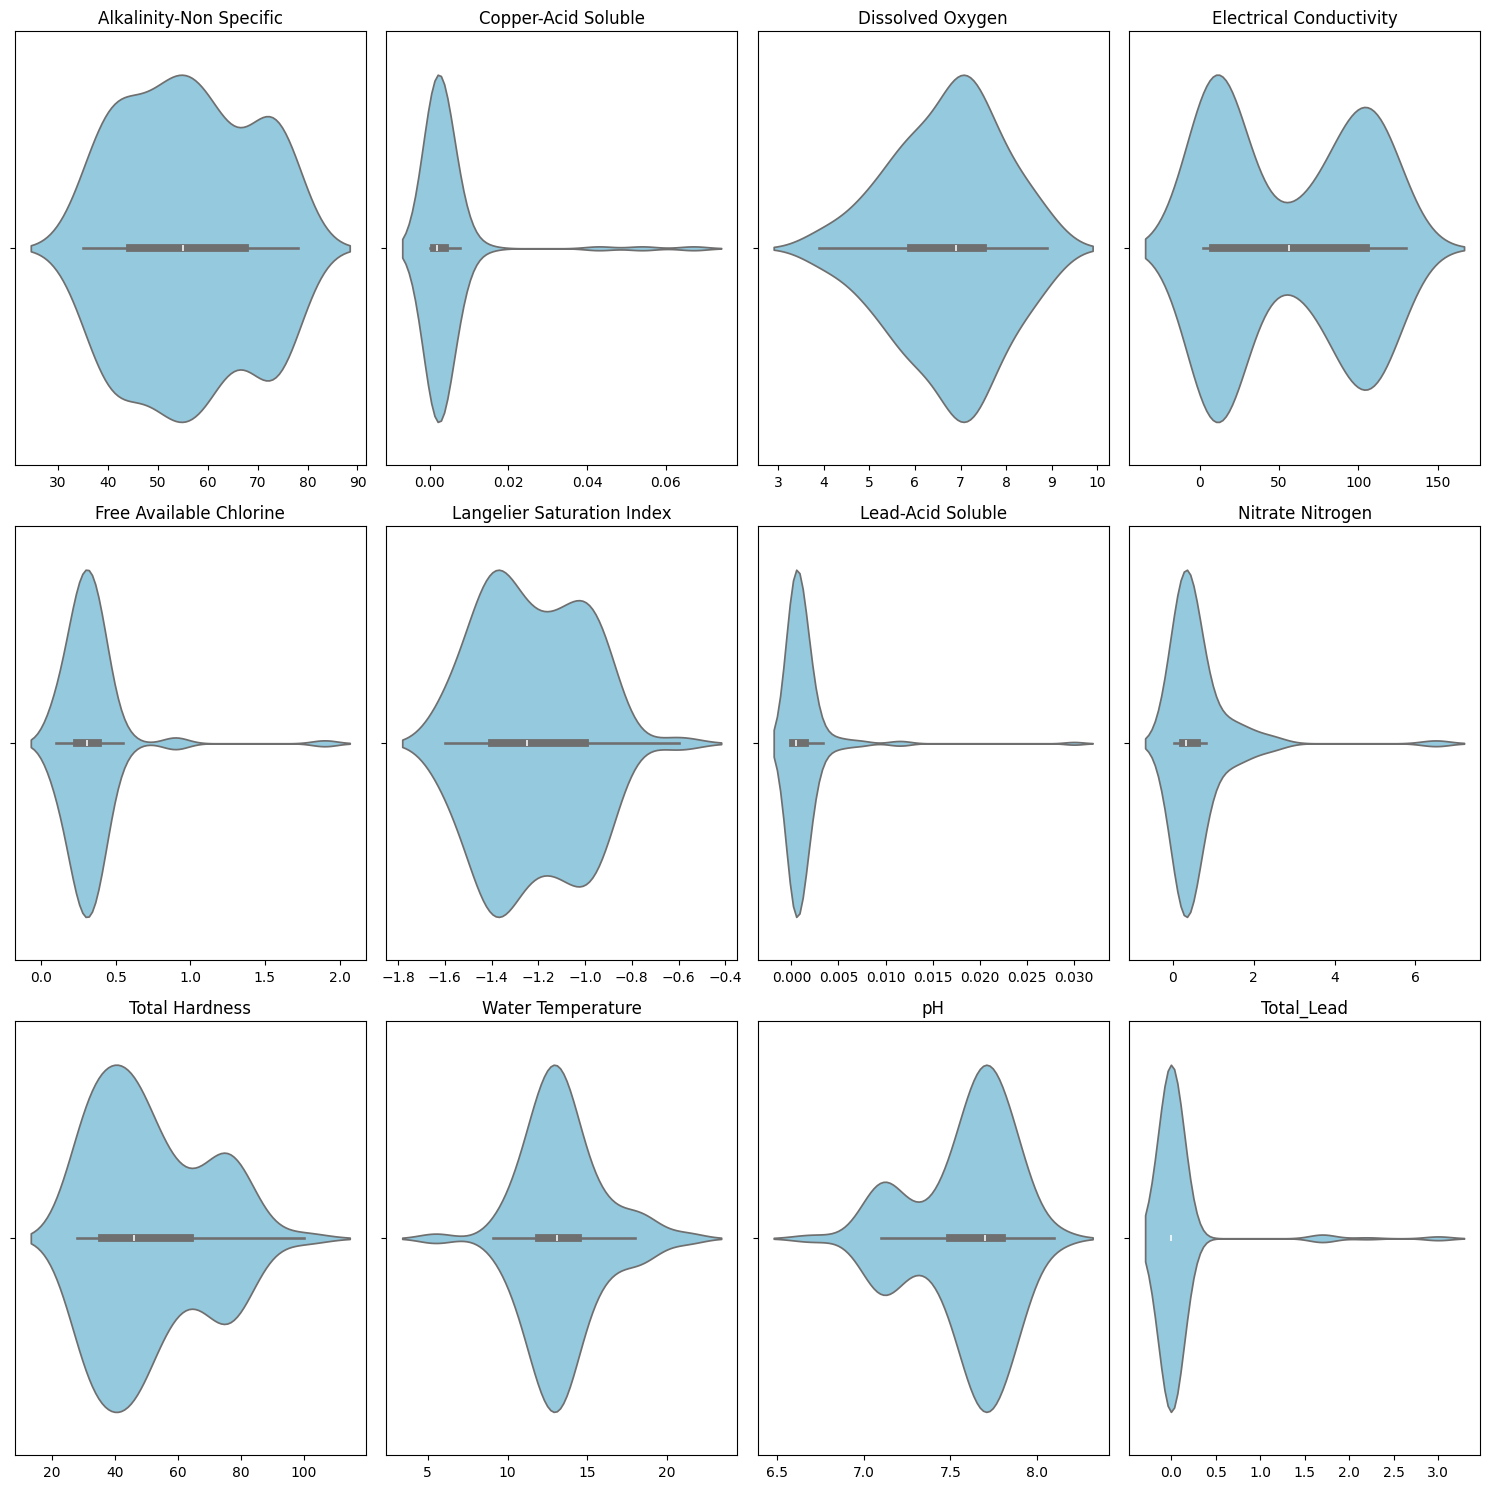

In [32]:
plot_violin(['Alkalinity-Non Specific', 'Copper-Acid Soluble', 
             'Dissolved Oxygen', 'Electrical Conductivity', 'Free Available Chlorine', 
             'Langelier Saturation Index', 'Lead-Acid Soluble', 'Nitrate Nitrogen', 
             'Total Hardness', 'Water Temperature', 'pH', 'Total_Lead'], 
            DZRowColDroped, 
            'C:/water analysis proj/Plumbosolvency/Plots')

<function matplotlib.pyplot.show(close=None, block=None)>

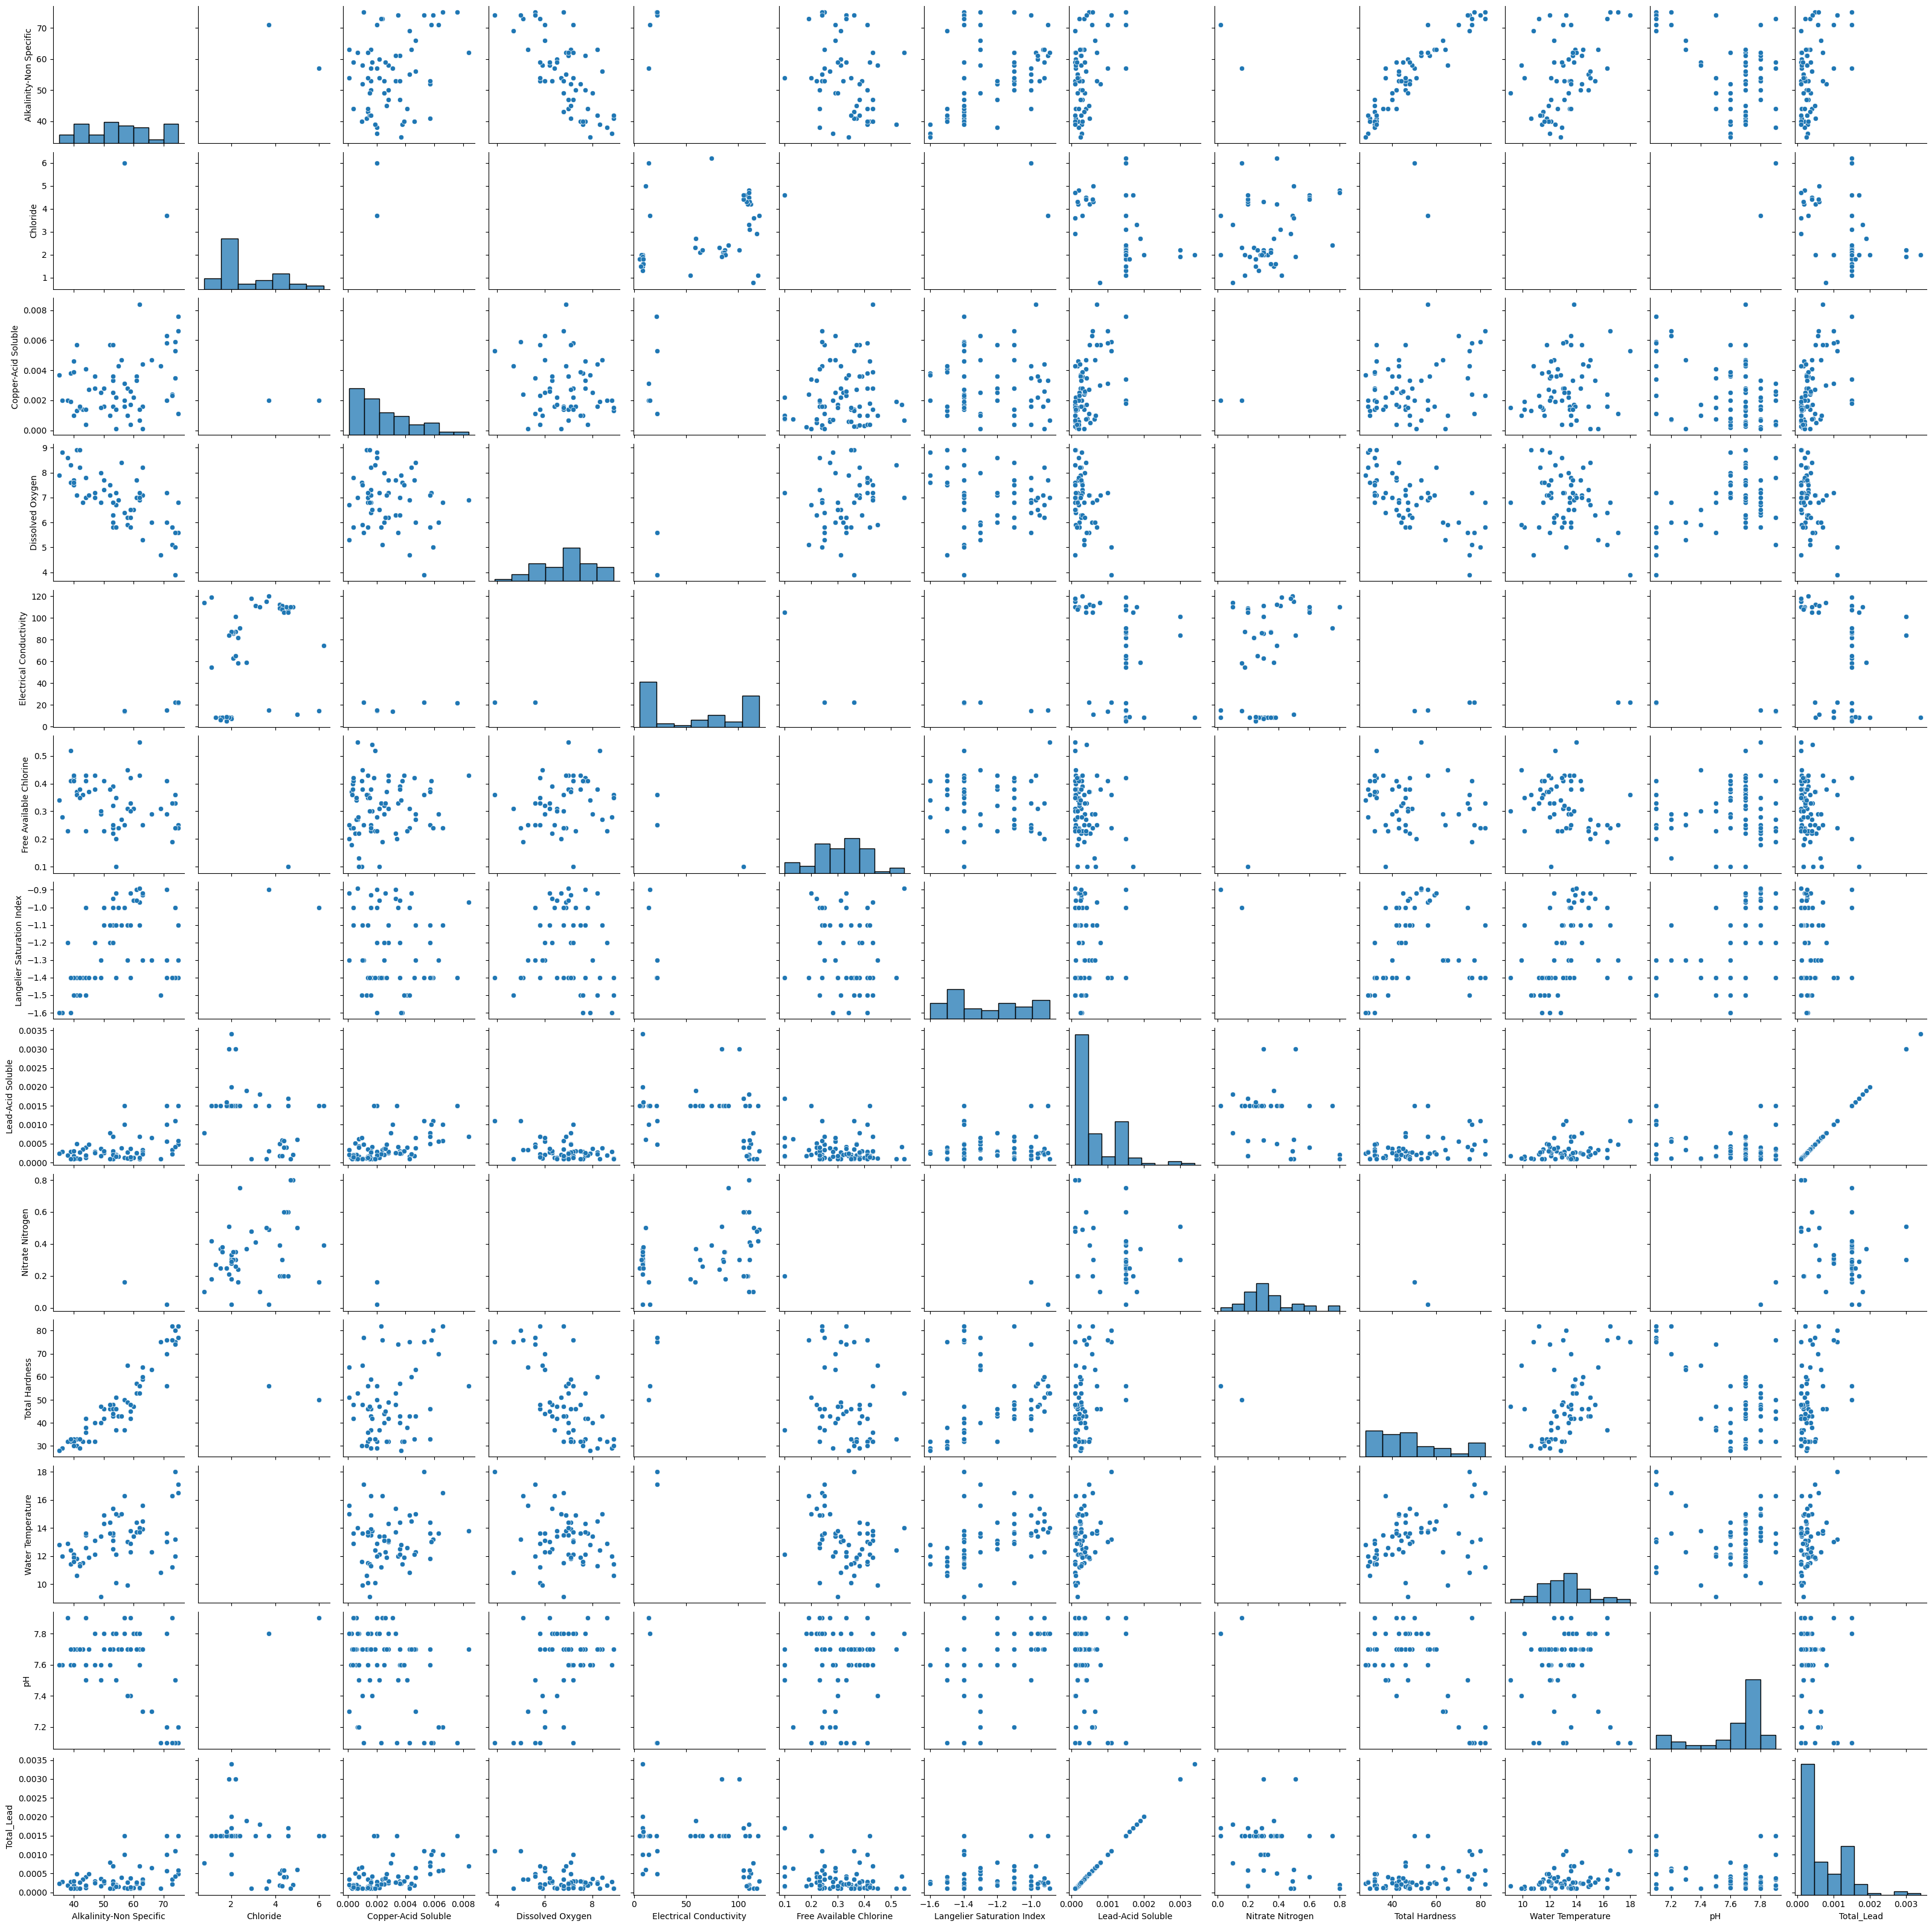

In [30]:
sns.pairplot(DZRowColDroped_without_outliers)
plt.savefig('C:\water analysis proj\Plumbosolvency\Plots\pair_plot.png')
plt.show

## Removing Outliers

In [24]:
def remove_outliers(df):
    df_cleaned = df.copy()
    for column in df_cleaned.select_dtypes(include='number').columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers that fall outside the bounds
        outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
        df_cleaned = df_cleaned.drop(outliers.index)
    
    return df_cleaned

## KNN Imputation

In [29]:
def KNNimpute_missing_values(DZdf):
    DZdf = DZdf.copy()
    DZdf['sample_date'] = pd.to_datetime(DZdf['sample_date'])
    DZdf['sample_date'] = (DZdf['sample_date'] - DZdf['sample_date'].min()).dt.days
    DZdf['reported_component_id'] = DZdf['reported_component_id'].astype('category').cat.codes
    categorical_cols = DZdf.select_dtypes(include=['object']).columns
    DZdf[categorical_cols] = DZdf[categorical_cols].astype('category').apply(lambda x: x.cat.codes)
    imputer = KNNImputer()
    imputed_df = imputer.fit_transform(DZdf)
    imputed_df = pd.DataFrame(imputed_df, columns=DZdf.columns)
    return imputed_df
Knn_df_imputed = KNNimpute_missing_values(DZRowColDroped_without_outliers)

In [28]:
DZRowColDroped_without_outliers = remove_outliers(DZRowColDroped)
DZRowColDroped_without_outliers.describe()

parameter_determinand,sample_date,Alkalinity-Non Specific,Chloride,Copper-Acid Soluble,Dissolved Oxygen,Electrical Conductivity,Free Available Chlorine,Langelier Saturation Index,Lead-Acid Soluble,Nitrate Nitrogen,Total Hardness,Water Temperature,pH,Total_Lead
count,144,65.000000,57.000000,89.000000,60.000000,61.000000,79.000000,64.000000,131.000000,54.000000,63.000000,62.000000,84.000000,144.000000
mean,2018-02-14 01:30:00,55.215385,2.753860,0.002478,6.870000,56.595902,0.310886,-1.226875,0.000673,0.333704,48.666667,13.140323,7.608333,0.000719
min,2008-10-13 00:00:00,35.000000,0.770000,0.000100,3.900000,5.280000,0.100000,-1.600000,0.000100,0.020000,28.000000,9.100000,7.100000,0.000100
25%,2014-10-09 18:00:00,45.000000,2.000000,0.000970,6.150000,8.400000,0.240000,-1.400000,0.000175,0.242500,36.500000,12.000000,7.575000,0.000188
50%,2019-10-01 00:00:00,54.000000,2.100000,0.002000,7.000000,58.900000,0.310000,-1.250000,0.000360,0.300000,46.000000,13.100000,7.700000,0.000410
75%,2021-06-21 12:00:00,62.000000,3.700000,0.003600,7.600000,105.000000,0.380000,-1.000000,0.001300,0.390000,56.500000,13.975000,7.800000,0.001500
max,2021-09-30 00:00:00,75.000000,6.200000,0.008400,8.900000,120.000000,0.550000,-0.890000,0.003400,0.800000,82.000000,18.000000,7.900000,0.003400
std,NaN,11.451654,1.299035,0.001931,1.062823,45.391941,0.101010,0.214497,0.000676,0.170397,15.438745,1.785227,0.232435,0.000669


In [543]:
def plot_distribution_comparison(before_imputation, after_imputation, column_names):
    num_columns = len(column_names)
    fig, axes = plt.subplots(1, num_columns, figsize=(10, 5))
    
       
    for i, column in enumerate(column_names):
        if column == 'Langelier Saturation Index':
            modified_column = 'LSI'
        elif column == 'Copper-Acid Soluble':
            modified_column = 'CopperAcid'
        elif column == 'Free Available Chlorine':
            modified_column = 'FAC'
        elif column == 'Electrical Conductivity':
            modified_column = 'ElectricalConductivity'
        elif column == 'Lead-Acid Soluble':
            modified_column = 'Lead'
        elif column == 'Total Hardness':
            modified_column = 'TotalHardness'
        elif column == 'Water Temperature':
            modified_column = 'WaterTemperature'
        else:
            modified_column = column
        
        sns.kdeplot(data=before_imputation[column], color='blue', fill=True, ax=axes[i])
        sns.kdeplot(data=after_imputation[column], color='green', fill=True, ax=axes[i])
        
        axes[i].set_title(modified_column)
        axes[i].set_xlabel('Value')
       # axes[i].set_ylabel('Density')
    
    fig.legend(['Before Imputation', 'After Imputation'], loc='center right')
    plt.savefig('C:\water analysis proj\Plumbosolvency\Plots\imputation_comparison_plot3.jpg')
    plt.tight_layout()
    plt.show()

## Comparing the sirstribution of data before and after Imputation

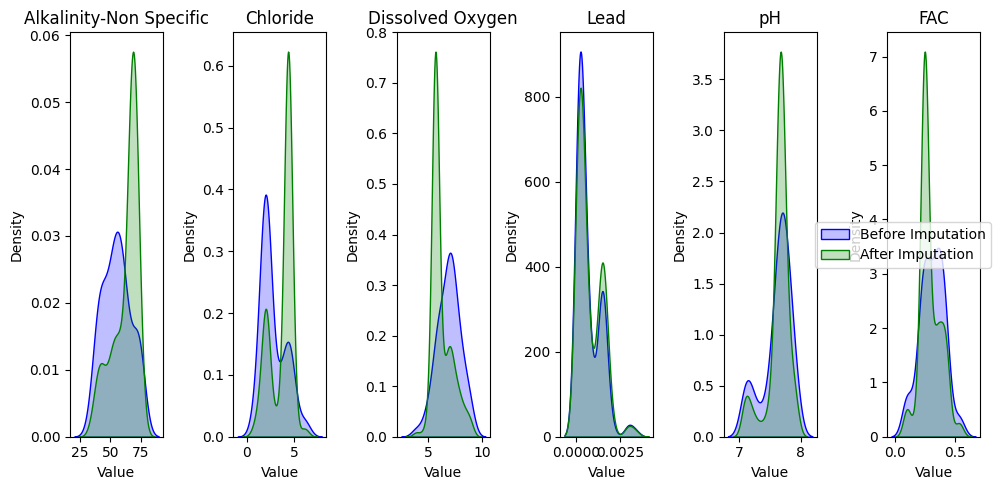

In [544]:
#plot_distribution_comparison(DZRowColDroped_without_outliers, df_imputed, ['Alkalinity-Non Specific', 'Chloride', 'Copper-Acid Soluble', 'Lead-Acid Soluble'])
plot_distribution_comparison(DZRowColDroped_without_outliers, Knn_df_imputed, ['Alkalinity-Non Specific', 'Chloride','Dissolved Oxygen','Lead-Acid Soluble','pH','Free Available Chlorine'])


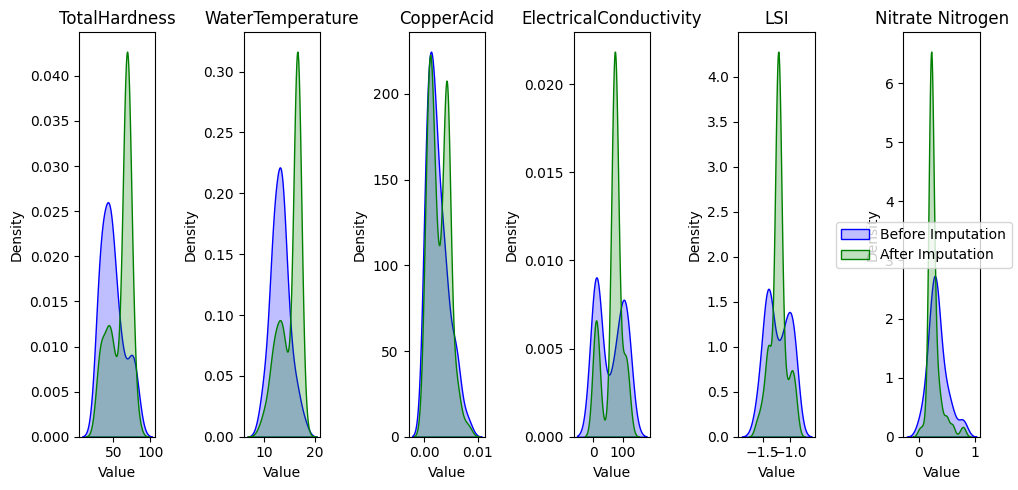

In [545]:
plot_distribution_comparison(DZRowColDroped_without_outliers, Knn_df_imputed, ['Total Hardness', 'Water Temperature', 'Copper-Acid Soluble', 'Electrical Conductivity','Langelier Saturation Index','Nitrate Nitrogen'])

## Correlation Analysis

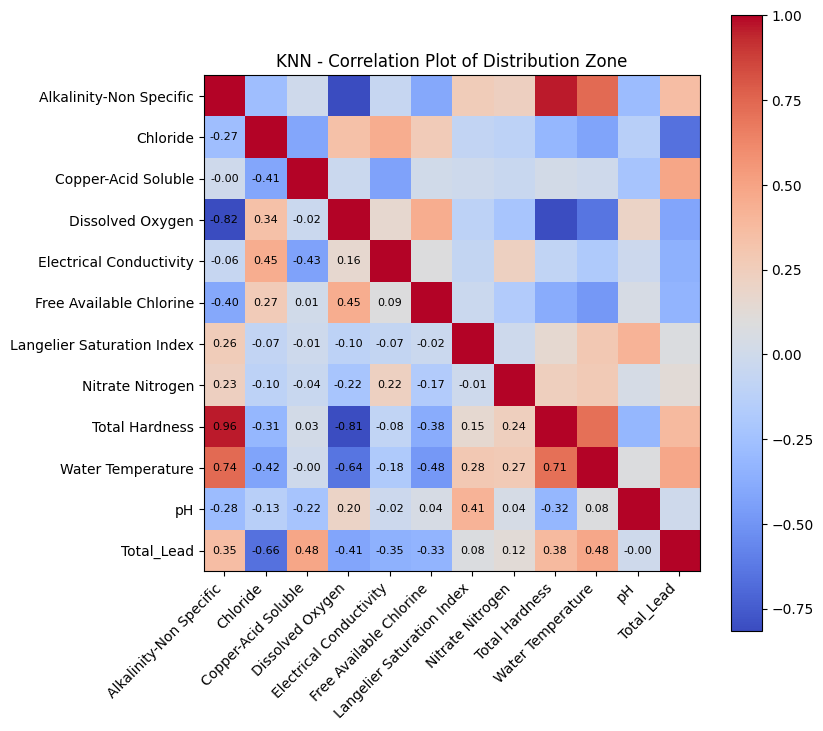

In [546]:
def plot_correlation(df, title):
    determinants_cols = df.columns[0:]  # Assuming you want to include all numeric columns starting from the 4th column
    correlation = df[determinants_cols].corr()
    plt.figure(figsize=(8, 8))
    plt.imshow(correlation, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    for i in range(len(correlation.columns)):
        for j in range(i + 1, len(correlation.columns)):
            plt.text(i, j, f"{correlation.iloc[i, j]:.2f}", ha='center', va='center', fontsize=8)
    plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=45, ha='right')
    plt.yticks(range(len(correlation.columns)), correlation.columns)
    plt.title(title)
    plt.savefig('C:\water analysis proj\Plumbosolvency\Plots\correlation_plot.png')
    plt.show()
DZCorrPlotdf_Knn = Knn_df_imputed.drop(columns=['Lead-Acid Soluble','sample_date','reported_component_id','old_supply_id'])
plot_correlation(DZCorrPlotdf_Knn, 'KNN - Correlation Plot of Distribution Zone')

In [547]:
def prepare_data(df_imp):
    columns_to_drop = ['sample_date', 'reported_component_id', 'Lead-Acid Soluble','old_supply_id']
    x_pred = None
    y_target = None
    if set(columns_to_drop).issubset(df_imp.columns):
        DZFinal = df_imp.drop(columns=columns_to_drop)
        if 'Total_Lead' in DZFinal.columns:
            x_pred = DZFinal.drop('Total_Lead', axis=1)
            y_target = DZFinal['Total_Lead']
        else:
            print("'Total_Lead' column not found in the DataFrame.")
    else:
        print("One or more columns to drop are not present in the DataFrame.")
    return x_pred, y_target
Knn_x_pred, Knn_y_target = prepare_data(Knn_df_imputed)
X_train, X_test, y_train, y_test = train_test_split(Knn_x_pred, Knn_y_target, test_size=0.2, random_state=42)

## Feature Selection

In [548]:
def plot_feature_importance_rf(X_train, y_train, n_features_to_select=6):
    np.random.seed(42)
    rf_regressor = RandomForestRegressor()
    rfe_selector = RFE(estimator=rf_regressor, n_features_to_select=n_features_to_select, step=1)
    rfe_selector.fit(X_train, y_train)
    feature_importances = rfe_selector.estimator_.feature_importances_
    features_selected = X_train.columns[rfe_selector.support_]
    sorted_indices = np.argsort(feature_importances)[::-1]
    feature_importances = feature_importances[sorted_indices]
    features_selected = features_selected[sorted_indices]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(range(len(features_selected)), feature_importances, align='center')
    plt.xticks(range(len(features_selected)), features_selected, rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Relative Importance (%)')
    plt.title('Relative Importance of Selected Features by Random Forest RFE')
    for bar, importance in zip(bars, feature_importances):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{importance:.2%}', 
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    print("Selected Features by RF", features_selected)

In [549]:
def plot_feature_importance_xgb(X_train, y_train, n_features_to_select=6):
    np.random.seed(42)

    # Train an XGBoost model
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X_train, y_train)
    feature_importances = xgb_model.feature_importances_
    selector = SelectFromModel(xgb_model, threshold='median')
    selector.fit(X_train, y_train)

    # Get selected features
    xgb_selected_features = X_train.columns[selector.get_support()]
    importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

    # Sort the features by importance score in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Select the top features
    top_features = importance_df.head(n=n_features_to_select)
    xgb_selected_features = X_train.columns[selector.get_support()]

    # Plot the bar plot for feature importances
    plt.figure(figsize=(8, 5))
    bars = plt.bar(range(len(top_features)), top_features['Importance'], align='center')
    plt.xticks(range(len(top_features)), top_features['Feature'], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance by XGBoost')

    # Add annotations (percentage of importance) on top of each bar
    for bar, importance in zip(bars, top_features['Importance']):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{importance:.2%}', 
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    plt.savefig('C:\water analysis proj\Plumbosolvency\Plots\XGBoostFeatureSelection.jpg')
    XGBoostFeatureslist =  top_features['Feature'].tolist()
    print("Selected Features by XGBoost:",xgb_selected_features)

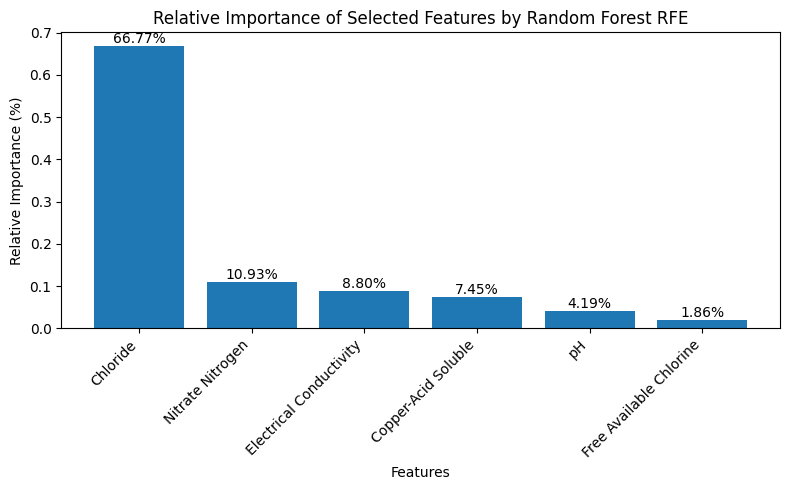

Selected Features by RF Index(['Chloride', 'Nitrate Nitrogen', 'Electrical Conductivity',
       'Copper-Acid Soluble', 'pH', 'Free Available Chlorine'],
      dtype='object', name='parameter_determinand')


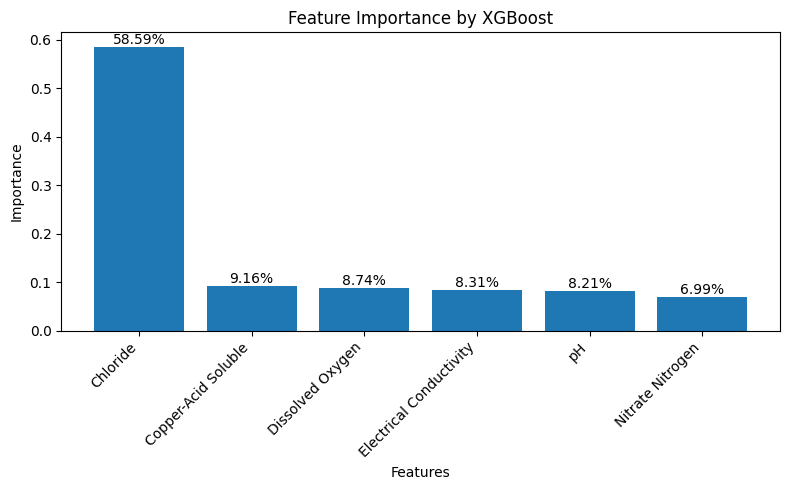

Selected Features by XGBoost: Index(['Chloride', 'Copper-Acid Soluble', 'Dissolved Oxygen',
       'Electrical Conductivity', 'Nitrate Nitrogen', 'pH'],
      dtype='object', name='parameter_determinand')


<Figure size 640x480 with 0 Axes>

In [551]:
plot_feature_importance_rf(X_train, y_train)
plot_feature_importance_xgb(X_train, y_train)
scaler = StandardScaler()
x_train_RF = scaler.fit_transform(X_train[features_selected])
x_test_RF = scaler.fit_transform(X_test[features_selected])
y_train_RF = y_train
y_test_RF = y_test
x_train_XG =  scaler.fit_transform(X_train[xgb_selected_features])
x_test_XG =  scaler.fit_transform(X_test[xgb_selected_features])
y_train_XG = y_train
y_test_XG = y_train

## Training the Model and Evaluvation

In [552]:
def evaluate_models(X_train_RF, X_test_RF, X_train_XG, X_test_XG, y_train, y_test):
    def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        fmodel = model.set_params(**best_params)
        fmodel.fit(X_train, y_train)
      
        train_pred = fmodel.predict(X_train)
        test_pred = fmodel.predict(X_test)

        train_mse = mean_squared_error(train_pred, y_train)
        test_mse = mean_squared_error(test_pred, y_test)
        train_mae = mean_absolute_error(train_pred, y_train)
        test_mae = mean_absolute_error(test_pred, y_test)
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        train_rmse = np.sqrt(train_mse)  
        test_rmse = np.sqrt(test_mse)
        train_residuals = y_train - train_pred
        return train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2, train_residuals, train_pred 
    
    param_grid = {
        "LinearRegression":{},
        "SVR": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        "XGBRegressor": {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200, 300]},
        "RandomForestRegressor": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
        "DecisionTreeRegressor": {'max_depth': [None, 10, 20]},
        "Lasso": {'alpha': [0.01, 0.1, 1, 10], 'selection': ['cyclic', 'random']}
    }
    
    models = [LinearRegression(),SVR(),XGBRegressor(), RandomForestRegressor(), DecisionTreeRegressor()]
    model_names = ["LinearRegression","SVR","XGBRegressor", "RandomForestRegressor", "DecisionTreeRegressor"]
    
    rf_results = []
    xg_results = []
    best_model = None
    best_model_name = None
    model_source = None
    best_test_r2 = float('-inf')
    best_test_rmse = float('inf')
    best_train_residuals = None
    best_train_pred = None
    best_test_pred = None
    best_y_test = None
    fbest_params =None
    best_test_mae = float('inf')

    for model, name in zip(models, model_names):
        rf_train_rmse, rf_test_rmse, rf_train_mae, rf_test_mae, rf_train_r2, rf_test_r2, rf_train_residuals, rf_train_pred = evaluate_model(model, name, X_train_RF, X_test_RF, y_train, y_test)
        rf_results.append([name, rf_train_rmse, rf_test_rmse, rf_train_mae, rf_test_mae, rf_train_r2, rf_test_r2])
        
        xg_train_rmse, xg_test_rmse, xg_train_mae, xg_test_mae, xg_train_r2, xg_test_r2, xg_train_residuals, xg_train_pred = evaluate_model(model, name, X_train_XG, X_test_XG, y_train, y_test)
        xg_results.append([name, xg_train_rmse, xg_test_rmse, xg_train_mae, xg_test_mae, xg_train_r2, xg_test_r2])

        if  rf_test_r2 > best_test_r2 or (rf_test_r2 == best_test_r2 and rf_test_rmse < best_test_rmse):
        #if rf_test_mae < best_test_mae:
            best_test_r2 = rf_test_r2
            best_test_rmse = rf_test_rmse
            best_test_mae = rf_test_mae
            best_model = model
            best_model_name = name
            model_source = "RandomForest"
            best_train_residuals = rf_train_residuals 
            best_train_pred = rf_train_pred
           #best_y_test = test_pred
        
        if  xg_test_r2 > best_test_r2 or (xg_test_r2 == best_test_r2 and xg_test_mse < best_test_mse):
        #if rf_test_mae < best_test_mae:
            best_test_r2 = xg_test_r2
            best_test_rmse = xg_test_rmse
            best_test_mae = xg_test_mae
            best_model = model
            best_model_name = name
            model_source = "XGBoost"
            best_train_residuals = xg_train_residuals
            best_train_pred = xg_train_pred

    best_model_source = "RandomForest Features" if model_source == "RandomForest" else "XGBoost Features"
   
    print(f"Best Model: {best_model_name} from {best_model_source}, Best Test RMSE: {best_test_rmse}")

    plt.figure(figsize=(10, 6))
    plt.scatter(best_train_pred, best_train_residuals, color='blue', alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f"Residual-Fitted Plot for Best Model : {best_model_name}")
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.savefig('C:\water analysis proj\Plumbosolvency\Plots\PredResidual.png')  
    plt.grid(True)
    plt.show()
    rf_results_df = pd.DataFrame(rf_results, columns=["Algorithm", "Training RMSE", "Testing RMSE", "Training MAE", "Testing MAE", "Training R2", "Testing R2"])
    xg_results_df = pd.DataFrame(xg_results, columns=["Algorithm", "Training RMSE", "Testing RMSE", "Training MAE", "Testing MAE", "Training R2", "Testing R2"])

    return rf_results_df, xg_results_df, best_model, best_model_source 


Best Model: XGBRegressor from XGBoost Features, Best Test RMSE: 0.00027483826369814135


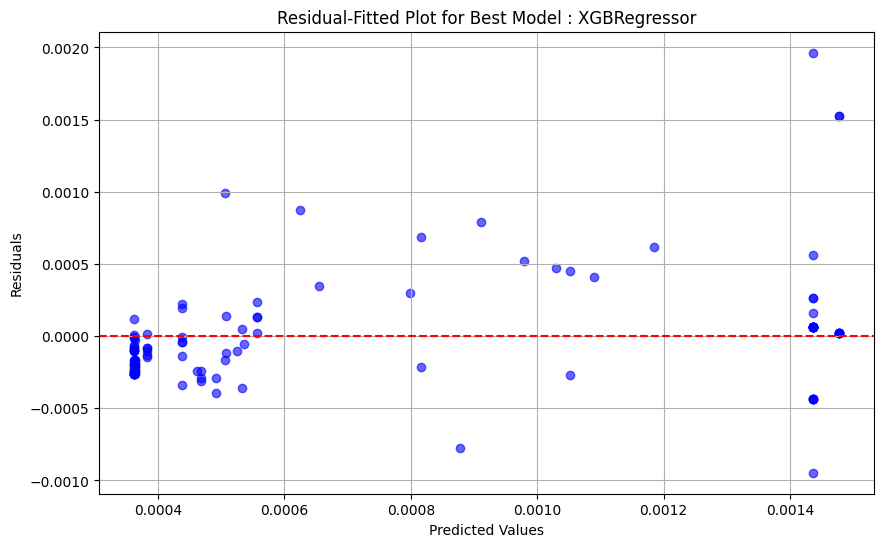

In [553]:
rf_results, xg_results, best_model, best_model_source = evaluate_models(x_train_RF, x_test_RF, x_train_XG, x_test_XG, y_train, y_test)

## Random Forest Features Results

In [497]:
rf_results


Random Forest Features Results:


,Algorithm,Training RMSE,Testing RMSE,Training MAE,Testing MAE,Training R2,Testing R2
0,LinearRegression,0.000481,0.000391,0.000313,0.000318,0.524685,0.408951
1,SVR,0.001222,0.001249,0.001081,0.001151,-2.065581,-5.031853
2,XGBRegressor,0.000404,0.000276,0.000263,0.000247,0.665177,0.705046
3,RandomForestRegressor,0.000211,0.000313,0.000119,0.000263,0.908671,0.619745
4,DecisionTreeRegressor,0.000092,0.000344,0.000012,0.000262,0.982513,0.540796


## XGBoost Features Results

In [554]:
xg_results

,Algorithm,Training RMSE,Testing RMSE,Training MAE,Testing MAE,Training R2,Testing R2
0,LinearRegression,0.000471,0.000359,0.000319,0.000277,0.544256,0.501824
1,SVR,0.001222,0.001249,0.001081,0.001151,-2.065581,-5.031853
2,XGBRegressor,0.000401,0.000275,0.000259,0.000236,0.669990,0.707713
3,RandomForestRegressor,0.000199,0.000324,0.000110,0.000263,0.918885,0.593679
4,DecisionTreeRegressor,0.000095,0.000352,0.000020,0.000277,0.981383,0.519392


## Deployment of the Selected Model

In [559]:
Knn_df_imputed_columns = Knn_df_imputed.columns.tolist()
Filtered_data = Applicationdata[Knn_df_imputed_columns]
threshold = len(Filtered_data.columns) * 0.3
Applicationdata_filtered = Filtered_data.dropna(thresh=threshold)
Applicationdata_filtered.reset_index(drop=True, inplace=True)
imputed_Applicationdata = KNNimpute_missing_values(Applicationdata_filtered)
Final_Applicationdata = imputed_Applicationdata.drop(columns=['Total_Lead'])
if best_model_source == "RandomForest Features":
    strlist_features = list(features_selected)
else:
    strlist_features = list(xgb_selected_features)
FA = Final_Applicationdata[strlist_features]
scaler = StandardScaler()
FA1= scaler.fit_transform(FA)

In [560]:
predictions = best_model.predict(FA1)
FA['Total_lead_predicted'] = predictions

C:\Users\ambil\AppData\Local\Temp\ipykernel_30076\2816873778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FA['Total_lead_predicted'] = predictions


## Prediction of Lead on the Selected Model

In [563]:
FA

parameter_determinand,Chloride,Copper-Acid Soluble,Dissolved Oxygen,Electrical Conductivity,Nitrate Nitrogen,pH,Total_lead_predicted
0,12.34,0.005000,3.76,24.26,0.0980,6.70,0.001253
1,12.34,0.005000,3.76,24.26,0.0980,7.90,0.001253
2,12.34,0.005000,3.76,24.26,0.1480,7.70,0.001253
3,12.34,0.005000,3.76,24.26,0.0980,7.00,0.001253
4,13.54,0.005000,3.76,26.78,0.0940,7.10,0.001253
...,...,...,...,...,...,...,...
5120,63.52,0.002388,3.82,67.02,0.7848,7.74,0.000884
5121,63.52,0.002388,3.82,54.04,0.7848,7.60,0.000884
5122,55.52,0.002320,5.38,25.30,0.7310,7.58,0.000741
5123,63.52,0.002388,3.82,54.04,0.7848,7.50,0.000884


## None of the Treatment plant records predicted Lead Values according the selected model is above MAV

In [562]:
# Count the number of rows where Total_lead_predicted is greater than 0.01
lead_counts = FA['Total_lead_predicted'].value_counts()
if len(lead_counts) == 1:
    print("All lead values are the same.")
else:
    print("Lead values vary in the dataset.")
count_lead_above_threshold = (FA['Total_lead_predicted'] > 0.01).sum()

print("Number of rows where Total_lead_predicted > 0.01:", count_lead_above_threshold)


Lead values vary in the dataset.
Number of rows where Total_lead_predicted > 0.01: 0
